In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import shap
import time
from numpy import concatenate

# Load training dataset

In [2]:
os.chdir('..\\Algal-bloom-prediction-machine-learning\\Trainning data')
file_name = input('file name of observation dataset:')
all_df = pd.read_csv(file_name,sep = ',',parse_dates = ['Date'])

file name of observation dataset:ME_Observation_df.csv


In [3]:
# Specify the training year
n_trainingyr = int(input('Number of training years:'))
year = []
for i in range(n_trainingyr):
    y=int(input('Year:'))
    year.append(y)
# Lake Erken: [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 

Number of training years:11
Year:1999
Year:2000
Year:2001
Year:2002
Year:2003
Year:2004
Year:2005
Year:2006
Year:2007
Year:2008
Year:2009


In [17]:
# Resample the dataset (Optional)
drop_row = []
dT = 0
i = 1
sample_df = all_df.copy()
while True:
    dT = (sample_df['Date'].iloc[i]-sample_df['Date'].iloc[i-1])/np.timedelta64(1, 'D')
    if dT<35: # set the data frequency (over 10, 14, 20 days)
        #print(sample_df['Date'].iloc[i])
        sample_df.drop(sample_df.index.values[i],axis = 0,inplace  =True)
    else:
        i+=1
    if i>=len(sample_df):break

# GBR model

In [14]:
def training_cv(df,features,nutrient,year):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    df = df[df['YY'].isin(year)]
    X_train = df[features]
    y_train = df[nutrient].values

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101).fit(X_train,y_train)
    rmse = -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_root_mean_squared_error')
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))

In [20]:
def predict(Erken_test,df,features,nutrient,test_time,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Erken_test[nutrient] =GBR.predict(Erken_test[features])
    nutrient_compare = Erken_test[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared = False)
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Erken_test.plot(x = 'Date',y =nutrient,style = 'b*',ax = ax2[0],label = 'Predicted '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((test_time[0],test_time[1]))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return test_df,f2

In [ ]:
# Train the model and 5-fold CV
n_features = int(input('Number of features:'))
features = []
for i in range(n_features):
    f = input('feature name:')
    features.append(f)
# Lake Erken:['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)','Ice_d','days from iceoff',
#           'NOX(mmole/m3)','NH4(mmole/m3)', 'PO4(mmole/m3)','TotP(mmole/m3)', 'Si(mmole/m3)','O2(mmole/m3)']
test_time = [pd.Timestamp(int(input('Test start in year:')),int(input('Test start in month:')),int(input('Test start on day:'))),
             pd.Timestamp(int(input('Test end in year:')),int(input('Test end in month:')),int(input('Test end in day:')))]
#os.chdir('..\\Scenario1\\GBR')
target = input('Target variable:')

In [16]:
training_cv(all_df,features,target,year)

Training dataset evaluation:
RMSE 5.14 (+/- 1.25)
R2 0.18 (+/- 0.14)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


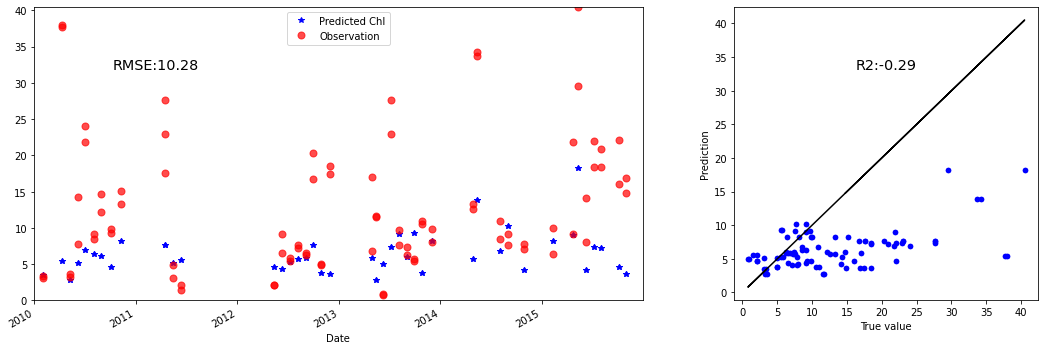

In [21]:
test_df = all_df[all_df['Date']>=test_time[0]]
ylim = (0,all_df[target].max())
test_df, f2 = predict(test_df,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

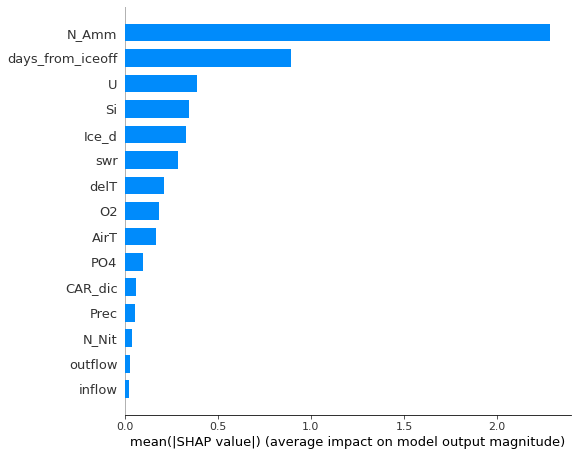

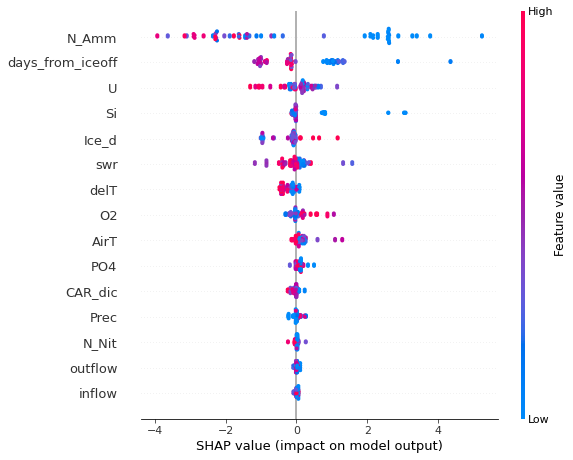

In [22]:
GBR = pickle.load(open('GBR.Chl.dat','rb'))
shap_values = shap.TreeExplainer(GBR).shap_values(test_df[features])
shap.summary_plot(shap_values,test_df[features],plot_type = 'bar')
shap.summary_plot(shap_values,test_df[features])

In [23]:
# Export the model results
test_df.to_csv('ME_GBR predicted Chl.csv',index = False)

# LSTM model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
Scaler = MinMaxScaler()

In [25]:
# Add the delta time feature into all_df
deltaT = []
dT = []
for i in range(1,len(all_df['Date'])):
    deltaT.append(all_df['Date'][i]-all_df['Date'][i-1])
    dT.append(deltaT[i-1]/np.timedelta64(1, 'D'))
dT.insert(0,np.nan)

all_df['Delta time'] = np.array(dT)
# delete the data points which have an over 14 days gap from previous sample point
all_df = all_df[all_df['Delta time']<=14]

In [39]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    drop_col =[]
    for i in range(1,n_in+1):
        drop_col += [n_vars*i-1]
    agg.drop(agg.iloc[:,drop_col],axis=1,inplace = True)
    return agg

In [26]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [27]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [28]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [64]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,date,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])

    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts.plot(y = 'Prediction',
                     style = 'b*',
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [30]:
def predict_ts(df,nutrient,model,values,hyperparameters):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, 
                               int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [31]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [65]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [33]:
# set the directory
os.chdir('..\\LSTM')
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':200,'dropout':0.1,'time_steps':1,'n_out':1,'verbose':0}

In [53]:
# predict Chl
features.append(target)
values = load_dataset(all_df,features) #values = values.astype('float32')
# frame as supervised learning
reframed = series_to_supervised(values,hyperparameters['time_steps'],hyperparameters['n_out'],features)
values = reframed.values

In [54]:
reframed.head()

,O2(t-1),CAR_dic(t-1),Si(t-1),N_Nit(t-1),PO4(t-1),N_Amm(t-1),delT(t-1),U(t-1),AirT(t-1),Prec(t-1),swr(t-1),inflow(t-1),outflow(t-1),Ice_d(t-1),days_from_iceoff(t-1),O2(t),CAR_dic(t),Si(t),N_Nit(t),PO4(t),N_Amm(t),delT(t),U(t),AirT(t),Prec(t),swr(t),inflow(t),outflow(t),Ice_d(t),days_from_iceoff(t),Chl(t)
1,359.375,3926.666667,2.607143,4.000000,3.096774,12.580645,0.042543,3.498471,6.930845,0.0000,137.660544,1.993531,1.516194,98.958333,197.0,409.375,3947.500000,36.071429,26.928571,2.870968,15.580645,-3.136722,2.427142,4.090003,0.9287,92.889750,5.643856,4.741300,78.0,-20.0,2.9
2,409.375,3947.500000,36.071429,26.928571,2.870968,15.580645,-3.136722,2.427142,4.090003,0.9287,92.889750,5.643856,4.741300,78.000000,-20.0,406.250,4033.333333,0.000000,33.357143,1.709677,7.290323,0.000000,4.233445,3.030419,0.9188,171.966957,4.467845,3.687625,78.0,8.0,10.1
3,406.250,4033.333333,0.000000,33.357143,1.709677,7.290323,0.000000,4.233445,3.030419,0.9188,171.966957,4.467845,3.687625,78.000000,8.0,315.625,3987.500000,8.571429,33.142857,0.903226,6.193548,5.595238,4.846104,13.173339,10.0168,95.453083,3.157959,4.989815,78.0,37.0,2.5
4,315.625,3987.500000,8.571429,33.142857,0.903226,6.193548,5.595238,4.846104,13.173339,10.0168,95.453083,3.157959,4.989815,78.000000,37.0,293.750,3756.666667,27.607143,36.000000,2.258065,7.870968,9.600816,2.044966,15.322085,0.0248,328.231371,54.337741,49.435608,78.0,65.0,3.1
5,293.750,3756.666667,27.607143,36.000000,2.258065,7.870968,9.600816,2.044966,15.322085,0.0248,328.231371,54.337741,49.435608,78.000000,65.0,268.750,3623.333333,36.071429,30.571429,1.580645,0.000000,15.174671,3.087298,21.475004,0.0204,318.036416,20.327559,25.470301,78.0,92.0,4.0


(66, 2, 15) (66,) (42, 2, 15) (42,)
number of input timesteps: 2
number of features: 15
number of samples: 66
Test RMSE: 11.39
Test R2: -0.48
Training dataset RMSE 5.22 (+/- 1.83)
Training dataset R2 -0.02 (+/- 0.23)
Model takes 1 min to run


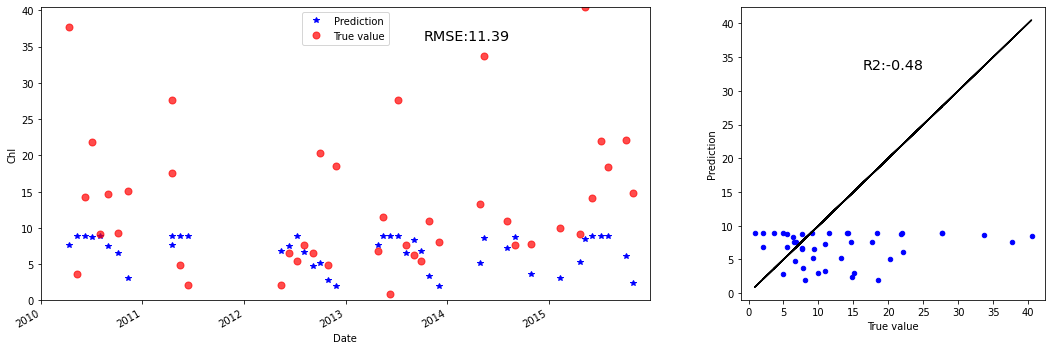

In [67]:
start_time = time.time()
Chl_model,RMSE,R2,figure = predict_lstm(all_df,values,features,target,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
os.chdir('..\\LSTM')
#figure.savefig('ME_LSTM_Chl.png',dpi = 500)

In [68]:
# use the trained model to interplate the whole timeseries
Nut_memory = all_df.copy()
Nut_memory[target] = np.nan
predict_ts(Nut_memory,target,Chl_model,values,hyperparameters)
Nut_memory.to_csv('ME_LSTM predicted Chl.csv',index = False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
